# KLambdaReweighting

Imports, open file

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="6"
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, Conv2D, Flatten, Dropout
import uproot
import numpy as np
import ptetaphi_nn
import tools
with open("filepath.txt", 'r') as f:
    filename = f.read().strip("\n")
    
s_table = tools.open_file(filename, sort_by="tag", pt_cut=40, eta_cut=2.5)
print(len(s_table.resolved_lv.pt), 'total events')

Using TensorFlow backend.
sorting data by tag
777150 total events


Filter events

In [2]:
nt3 = s_table.nbtags==3  # 3 b tags
events = s_table[nt3]
print(len(events), 'events with 3 tags')


cutoff = 10  # not many events have >10 jets
# "pad" = ensure all events have same length, cut off ends if needed
events = tools.pad(events, cutoff)

287645 events with 3 tags


Create network

In [3]:
nn = ptetaphi_nn.PtEtaPhiNN(events, load=("models/architecture_23_07_2020.json", "models/weights_23_07_2020.h5"), njets=10, chop=0, print_summary=True)

Loading model... 
Using architecture: models/architecture_23_07_2020.json 
and weights: models/weights_23_07_2020.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 700)               21700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               350500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               150300    
___

Evaluate network

100%|██████████| 287645/287645 [00:04<00:00, 62858.16it/s]
overall accuracy: 90.88 percent
ignoring 1.44 percent (4137 events) of 287645 events


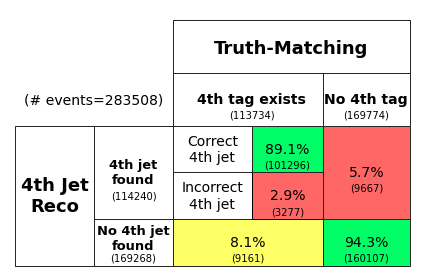

In [4]:
selections = nn.evaluate(events, savename='before_weighting')

In [5]:
truth = events.truth
tag = events.tag


get events with 3 tags (all of them) and 1 selection

In [6]:
one_selected = np.count_nonzero(selections, axis=1)

events_with_4 = events[one_selected == 1]
print(len(events_with_4))

# then for each event here take the first 3 tagged jets and selected jets
tag_os = tag[one_selected == 1]
truth_os = truth[one_selected == 1]
selections_os = selections[one_selected == 1]

selected_n = np.where(selections_os==1)[1]

pt4 = []
eta4 = []
phi4 = []
E4 = []

pt = events_with_4.resolved_lv.pt
eta = events_with_4.resolved_lv.eta
phi = events_with_4.resolved_lv.phi
E = events_with_4.resolved_lv.E

from tqdm import tqdm
padded = np.zeros(len(events_with_4))
for i in tqdm(range(len(events_with_4))):
    if selected_n[i] < len(pt[i]):
        pt4.append(pt[i,[1,2,3,selected_n[i]]])
        eta4.append(eta[i,[1,2,3,selected_n[i]]])
        phi4.append(phi[i,[1,2,3,selected_n[i]]])
        E4.append(E[i,[1,2,3,selected_n[i]]])
    else:
        padded[i] = 1

pt4 = np.array(pt4)
eta4 = np.array(eta4)
phi4 = np.array(phi4)
E4 = np.array(E4)

print('\npicked a padded jet', np.count_nonzero(padded), 'times')

100%|██████████| 117849/117849 [00:05<00:00, 20038.22it/s]

picked a padded jet 563 times


100%|██████████| 117286/117286 [00:06<00:00, 18623.22it/s]


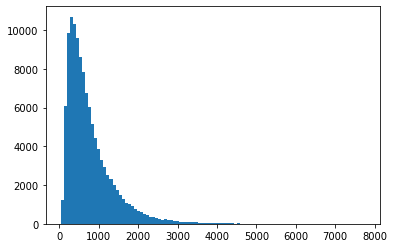

In [7]:
# now calculate m_HH
m_HH = np.empty(len(pt4))

for i in tqdm(range(len(pt4))):
    m_HH[i] = np.sqrt(np.sum(E4[i])**2 - np.linalg.norm(np.sum(pt4[i]))**2)

import matplotlib.pyplot as plt
plt.hist(m_HH, bins=100)
plt.show()


In [8]:
import uproot
import pandas

# open file
sm_file = uproot.open(filename)

# get all data in tree format
sm_tree = sm_file['XhhMiniNtuple']
for k in sm_tree.keys():
    if 'eight' in str(k):
        print(k)


b'mcEventWeight'
b'weight_pileup'
b'weight'
b'weight_xs'


In [9]:
import awkward
# get branches we care about
branches = sm_tree.arrays(branches=[
    'mcEventWeight'], namedecode='utf-8')
# convert to "pandas-dataframe-style" table
table = awkward.Table(branches)
table = table[nt3][one_selected==1][padded==0]

# Open the lambda weights file
lambda_file=uproot.open("LambdaWeightFile.root")

weights_dict = {}

for key in lambda_file.keys():
    # get bin info for each value of lambda
    bins = lambda_file[key]
    # find out which bin each event belongs to
    bin_indices = np.digitize(m_HH,bins.edges) 
    # key = b'weight_lambda[lambda_value];1'
    lambda_value = key.decode()[13:][:-2]
    # get weighted data = bin index * monte carlo scale factor
    weights_dict[f'w_lambda{lambda_value}'] = bins.allvalues[bin_indices] * table['mcEventWeight']


In [10]:
print(weights_dict.keys())
print(len(events), len(events_with_4))
print(sum(weights_dict['w_lambda01']), len(weights_dict['w_lambda01']))

dict_keys(['w_lambda-20', 'w_lambda-19', 'w_lambda-18', 'w_lambda-17', 'w_lambda-16', 'w_lambda-15', 'w_lambda-14', 'w_lambda-13', 'w_lambda-12', 'w_lambda-11', 'w_lambda-10', 'w_lambda-09', 'w_lambda-08', 'w_lambda-07', 'w_lambda-06', 'w_lambda-05', 'w_lambda-04', 'w_lambda-03', 'w_lambda-02', 'w_lambda-01', 'w_lambda00', 'w_lambda01', 'w_lambda02', 'w_lambda03', 'w_lambda04', 'w_lambda05', 'w_lambda06', 'w_lambda07', 'w_lambda08', 'w_lambda09', 'w_lambda10', 'w_lambda11', 'w_lambda12', 'w_lambda13', 'w_lambda14', 'w_lambda15', 'w_lambda16', 'w_lambda17', 'w_lambda18', 'w_lambda19', 'w_lambda20'])
287645 117849
1760.0842123818334 117286


w_lambda-20
using weights
100%|██████████| 287645/287645 [00:04<00:00, 62271.69it/s]
overall accuracy: 92.87 percent
ignoring 1.44 percent (4137 events) of 287645 events


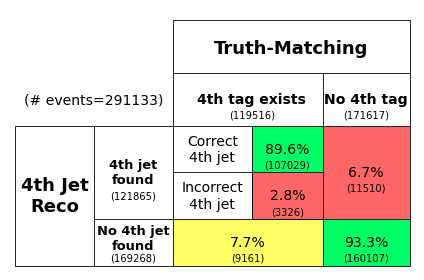

w_lambda-19
using weights
100%|██████████| 287645/287645 [00:04<00:00, 62287.72it/s]
overall accuracy: 92.67 percent
ignoring 1.44 percent (4137 events) of 287645 events


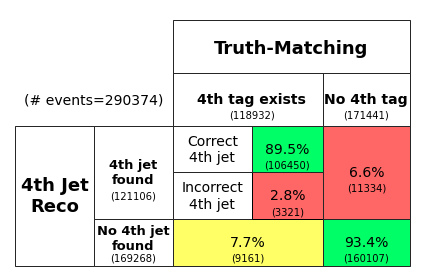

w_lambda-18
using weights
100%|██████████| 287645/287645 [00:04<00:00, 60932.79it/s]
overall accuracy: 92.48 percent
ignoring 1.44 percent (4137 events) of 287645 events


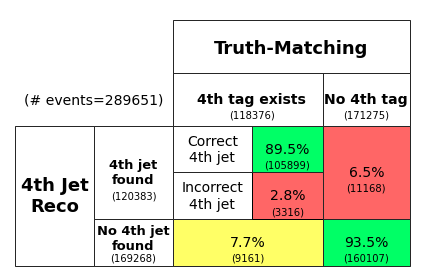

w_lambda-17
using weights
100%|██████████| 287645/287645 [00:04<00:00, 61575.77it/s]
overall accuracy: 92.30 percent
ignoring 1.44 percent (4137 events) of 287645 events


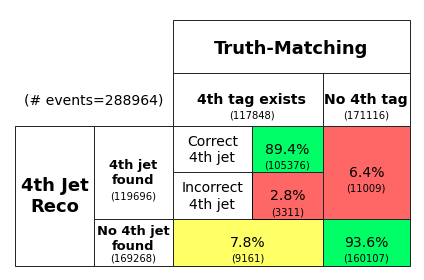

w_lambda-16
using weights
100%|██████████| 287645/287645 [00:04<00:00, 60579.29it/s]
overall accuracy: 92.12 percent
ignoring 1.44 percent (4137 events) of 287645 events


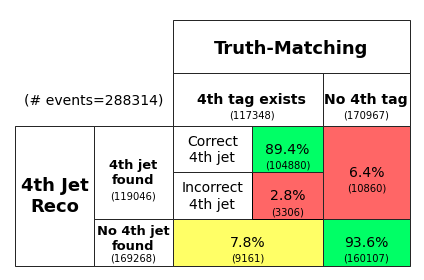

w_lambda-15
using weights
100%|██████████| 287645/287645 [00:04<00:00, 60380.61it/s]
overall accuracy: 91.96 percent
ignoring 1.44 percent (4137 events) of 287645 events


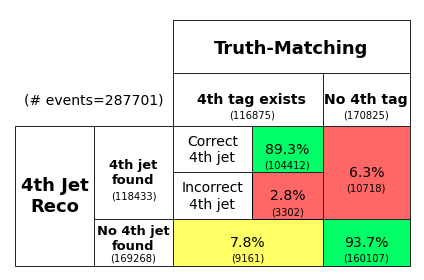

w_lambda-14
using weights
100%|██████████| 287645/287645 [00:04<00:00, 59686.90it/s]
overall accuracy: 91.81 percent
ignoring 1.44 percent (4137 events) of 287645 events


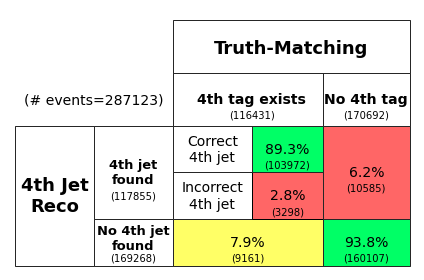

w_lambda-13
using weights
100%|██████████| 287645/287645 [00:04<00:00, 59272.49it/s]
overall accuracy: 91.66 percent
ignoring 1.44 percent (4137 events) of 287645 events


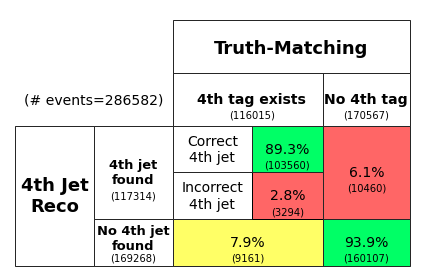

w_lambda-12
using weights
100%|██████████| 287645/287645 [00:04<00:00, 59988.44it/s]
overall accuracy: 91.53 percent
ignoring 1.44 percent (4137 events) of 287645 events


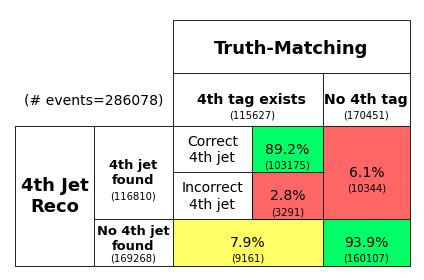

w_lambda-11
using weights
100%|██████████| 287645/287645 [00:04<00:00, 58057.81it/s]
overall accuracy: 91.41 percent
ignoring 1.44 percent (4137 events) of 287645 events


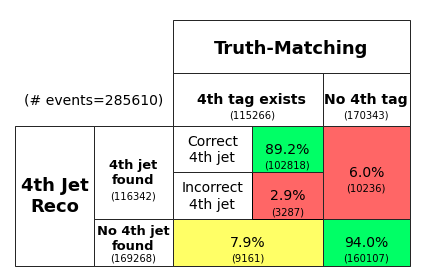

w_lambda-10
using weights
100%|██████████| 287645/287645 [00:05<00:00, 57203.08it/s]
overall accuracy: 91.29 percent
ignoring 1.44 percent (4137 events) of 287645 events


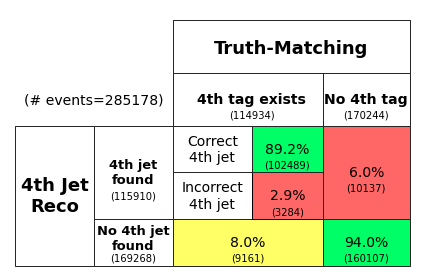

w_lambda-09
using weights
100%|██████████| 287645/287645 [00:04<00:00, 58265.28it/s]
overall accuracy: 91.19 percent
ignoring 1.44 percent (4137 events) of 287645 events


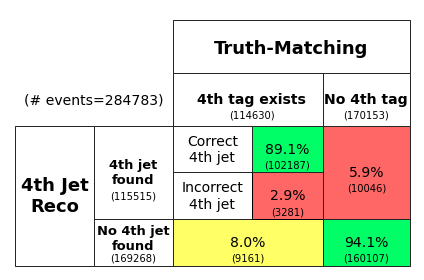

w_lambda-08
using weights
100%|██████████| 287645/287645 [00:04<00:00, 57884.06it/s]
overall accuracy: 91.09 percent
ignoring 1.44 percent (4137 events) of 287645 events


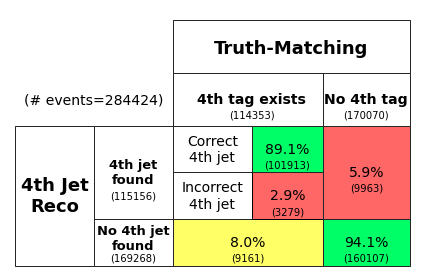

w_lambda-07
using weights
100%|██████████| 287645/287645 [00:05<00:00, 56423.51it/s]
overall accuracy: 91.01 percent
ignoring 1.44 percent (4137 events) of 287645 events


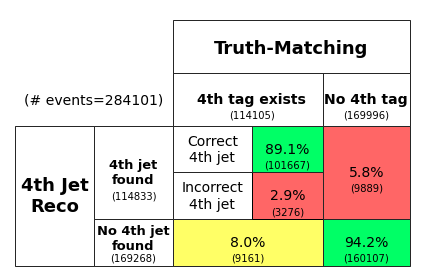

w_lambda-06
using weights
100%|██████████| 287645/287645 [00:04<00:00, 59629.32it/s]
overall accuracy: 90.93 percent
ignoring 1.44 percent (4137 events) of 287645 events


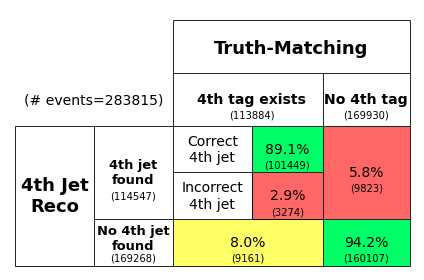

w_lambda-05
using weights
100%|██████████| 287645/287645 [00:05<00:00, 56991.22it/s]
overall accuracy: 90.86 percent
ignoring 1.44 percent (4137 events) of 287645 events


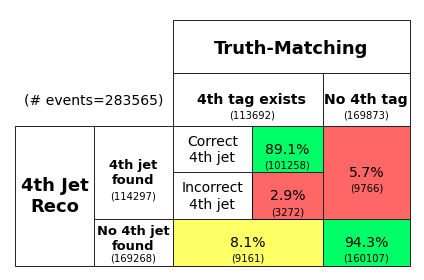

w_lambda-04
using weights
100%|██████████| 287645/287645 [00:05<00:00, 57175.10it/s]
overall accuracy: 90.81 percent
ignoring 1.44 percent (4137 events) of 287645 events


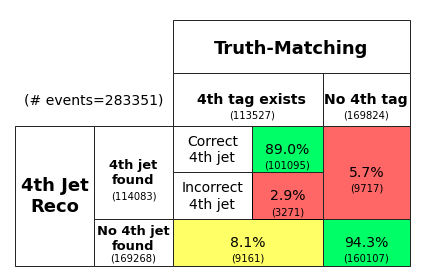

w_lambda-03
using weights
100%|██████████| 287645/287645 [00:04<00:00, 57876.06it/s]
overall accuracy: 90.76 percent
ignoring 1.44 percent (4137 events) of 287645 events


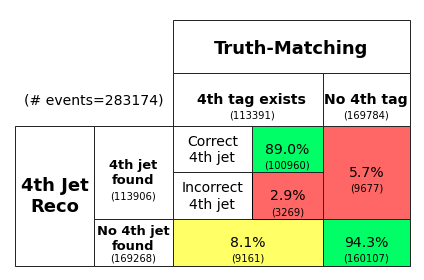

w_lambda-02
using weights
100%|██████████| 287645/287645 [00:05<00:00, 56373.41it/s]
overall accuracy: 90.72 percent
ignoring 1.44 percent (4137 events) of 287645 events


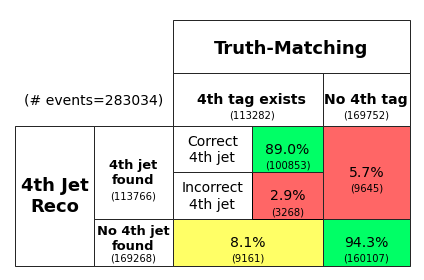

w_lambda-01
using weights
100%|██████████| 287645/287645 [00:05<00:00, 55594.95it/s]
overall accuracy: 90.70 percent
ignoring 1.44 percent (4137 events) of 287645 events


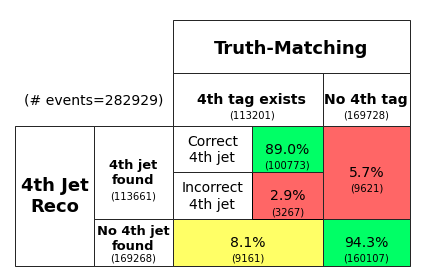

w_lambda00
using weights
100%|██████████| 287645/287645 [00:05<00:00, 55102.36it/s]
overall accuracy: 90.68 percent
ignoring 1.44 percent (4137 events) of 287645 events


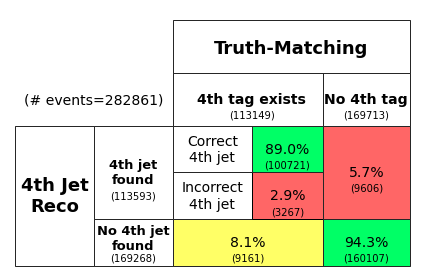

w_lambda01
using weights
100%|██████████| 287645/287645 [00:05<00:00, 52120.07it/s]
overall accuracy: 90.67 percent
ignoring 1.44 percent (4137 events) of 287645 events


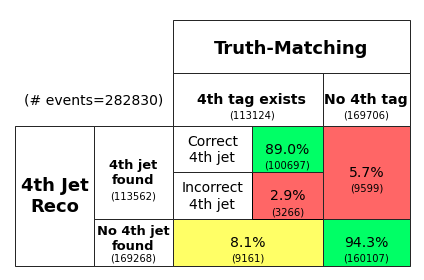

w_lambda02
using weights
100%|██████████| 287645/287645 [00:05<00:00, 55081.60it/s]
overall accuracy: 90.67 percent
ignoring 1.44 percent (4137 events) of 287645 events


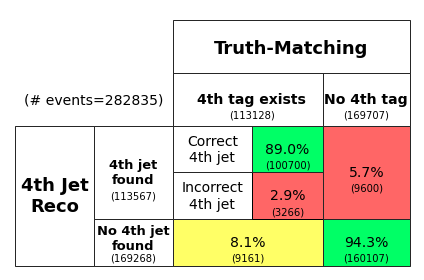

w_lambda03
using weights
100%|██████████| 287645/287645 [00:05<00:00, 55328.94it/s]
overall accuracy: 90.68 percent
ignoring 1.44 percent (4137 events) of 287645 events


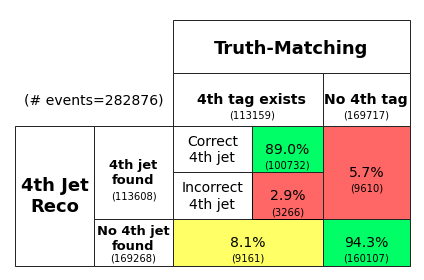

w_lambda04
using weights
100%|██████████| 287645/287645 [00:05<00:00, 54150.35it/s]
overall accuracy: 90.70 percent
ignoring 1.44 percent (4137 events) of 287645 events


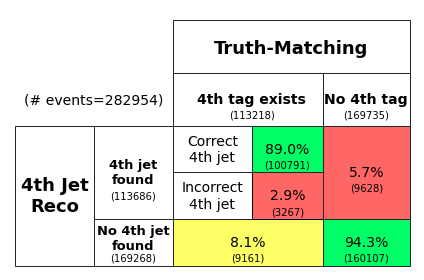

w_lambda05
using weights
100%|██████████| 287645/287645 [00:05<00:00, 53801.65it/s]
overall accuracy: 90.73 percent
ignoring 1.44 percent (4137 events) of 287645 events


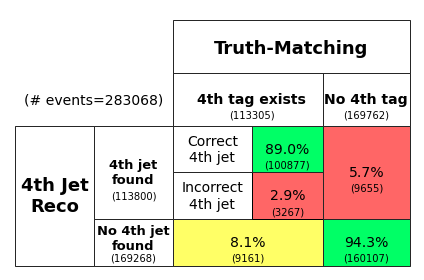

w_lambda06
using weights
100%|██████████| 287645/287645 [00:05<00:00, 54994.40it/s]
overall accuracy: 90.77 percent
ignoring 1.44 percent (4137 events) of 287645 events


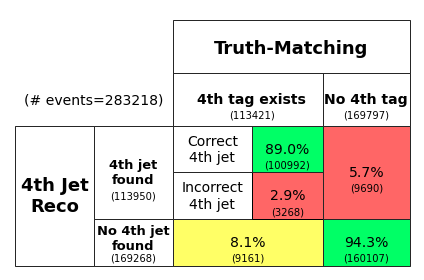

w_lambda07
using weights
100%|██████████| 287645/287645 [00:05<00:00, 54558.81it/s]
overall accuracy: 90.82 percent
ignoring 1.44 percent (4137 events) of 287645 events


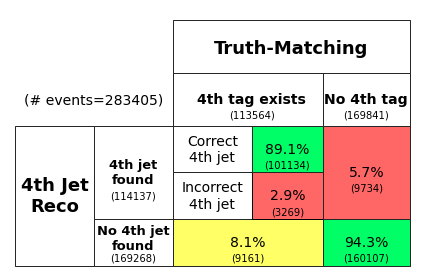

w_lambda08
using weights
100%|██████████| 287645/287645 [00:05<00:00, 56182.86it/s]
overall accuracy: 90.88 percent
ignoring 1.44 percent (4137 events) of 287645 events


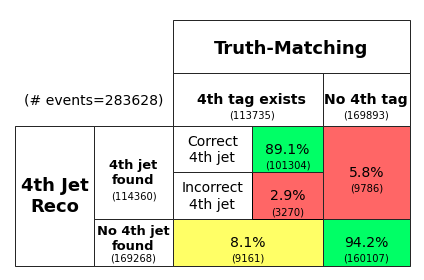

w_lambda09
using weights
100%|██████████| 287645/287645 [00:05<00:00, 53637.08it/s]
overall accuracy: 90.95 percent
ignoring 1.44 percent (4137 events) of 287645 events


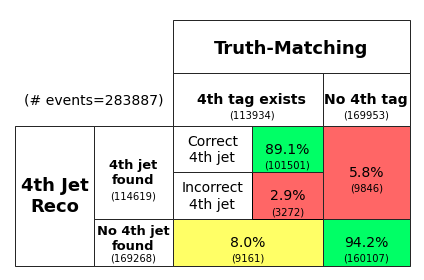

w_lambda10
using weights
100%|██████████| 287645/287645 [00:05<00:00, 53462.30it/s]
overall accuracy: 91.03 percent
ignoring 1.44 percent (4137 events) of 287645 events


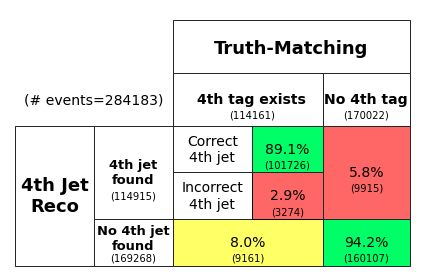

w_lambda11
using weights
100%|██████████| 287645/287645 [00:05<00:00, 53470.79it/s]
overall accuracy: 91.11 percent
ignoring 1.44 percent (4137 events) of 287645 events


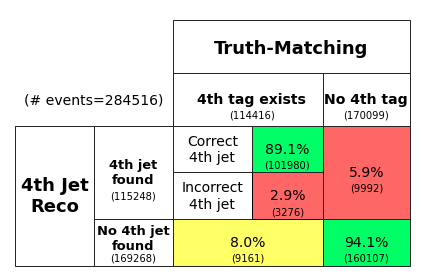

w_lambda12
using weights
100%|██████████| 287645/287645 [00:05<00:00, 53516.03it/s]
overall accuracy: 91.21 percent
ignoring 1.44 percent (4137 events) of 287645 events


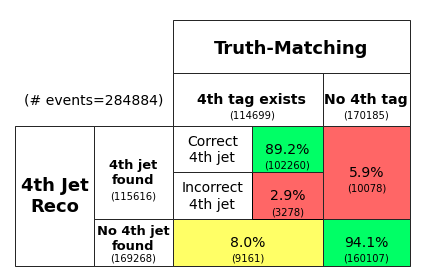

w_lambda13
using weights
100%|██████████| 287645/287645 [00:05<00:00, 52770.46it/s]
overall accuracy: 91.32 percent
ignoring 1.44 percent (4137 events) of 287645 events


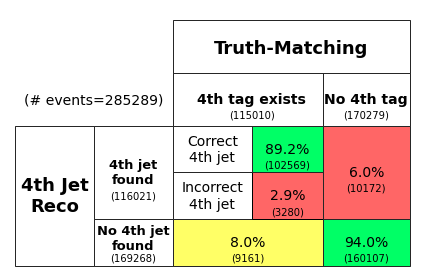

w_lambda14
using weights
100%|██████████| 287645/287645 [00:05<00:00, 52442.27it/s]
overall accuracy: 91.44 percent
ignoring 1.44 percent (4137 events) of 287645 events


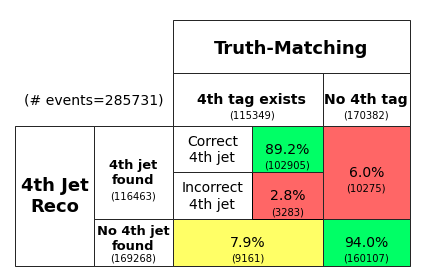

w_lambda15
using weights
100%|██████████| 287645/287645 [00:05<00:00, 52841.53it/s]
overall accuracy: 91.56 percent
ignoring 1.44 percent (4137 events) of 287645 events


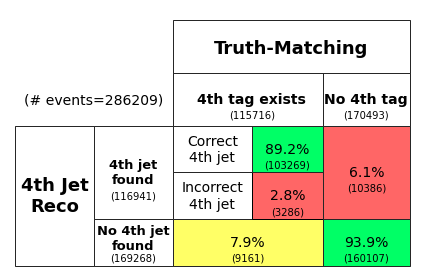

w_lambda16
using weights
100%|██████████| 287645/287645 [00:05<00:00, 53107.63it/s]
overall accuracy: 91.70 percent
ignoring 1.44 percent (4137 events) of 287645 events


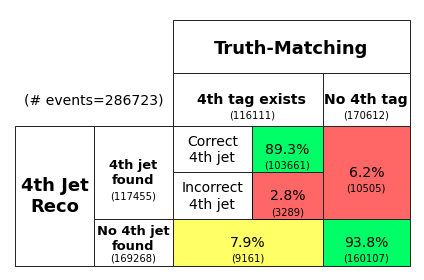

w_lambda17
using weights
100%|██████████| 287645/287645 [00:05<00:00, 52920.84it/s]
overall accuracy: 91.84 percent
ignoring 1.44 percent (4137 events) of 287645 events


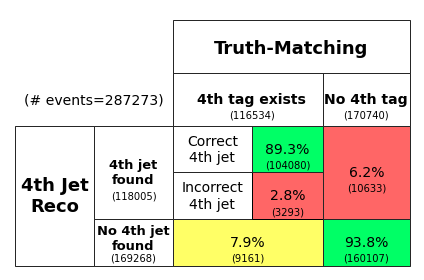

w_lambda18
using weights
100%|██████████| 287645/287645 [00:05<00:00, 54088.56it/s]
overall accuracy: 92.00 percent
ignoring 1.44 percent (4137 events) of 287645 events


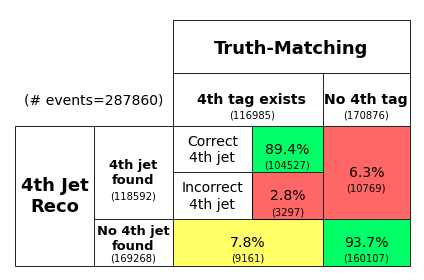

w_lambda19
using weights
100%|██████████| 287645/287645 [00:05<00:00, 53599.95it/s]
overall accuracy: 92.17 percent
ignoring 1.44 percent (4137 events) of 287645 events


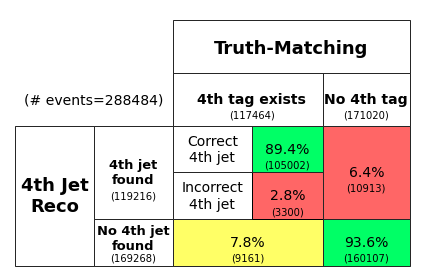

w_lambda20
using weights
100%|██████████| 287645/287645 [00:05<00:00, 53730.26it/s]
overall accuracy: 92.34 percent
ignoring 1.44 percent (4137 events) of 287645 events


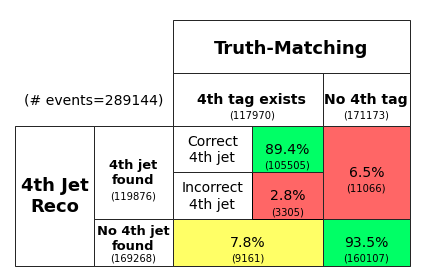

In [11]:
for k in weights_dict.keys():
    print(k)
    # weights are for events where one non-padding jet was selected 
    weights = weights_dict[k]
    allweights = np.ones(len(events))
    w_counter = 0
    for i in range(len(events)):
        if one_selected[i]:
            if selected_n[w_counter] < len(pt[w_counter]):
                allweights[i] = weights[w_counter]
                w_counter += 1
        # else just leave it as one
    nn.evaluate(events, weights=allweights, savename=k)

100%|██████████| 287645/287645 [00:04<00:00, 64954.91it/s]
overall accuracy: 90.88 percent
ignoring 1.44 percent (4137 events) of 287645 events


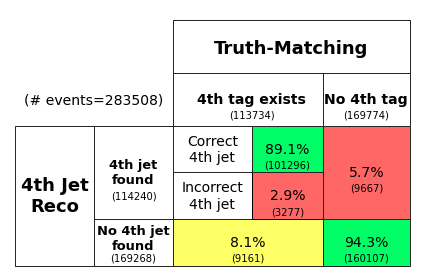

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
nn.evaluate(events, savename="with_cuts")